# Learning to Crawl with Q-Learning

In [144]:
%pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np, numpy.random as nr
import gymnasium as gym

import matplotlib.pyplot as plt
%matplotlib inline

from crawler_env import KTAICrawlerEnv


np.set_printoptions(precision=3)
import time

Let's run the crawler environment with a random policy. You will see the random controller can sometimes make progress but it won't get very far. 

In [2]:
env = KTAICrawlerEnv(
    render=True, # turn render mode on to visualize random motion
)

# standard procedure for interfacing with a Gym environment
cur_state = env.reset() # reset environment and get initial state
ret = 0.
done = False
i = 0
while not done:
    action = env.action_space.sample() # sample an action randomly
    next_state, reward, done, info = env.step(action)
    ret += reward
    cur_state = next_state
    time.sleep(0.01)
    i += 1
    if i == 1500:
        break # for the purpose of this visualization, let's only run for 1500 steps
        # also note the GUI won't close automatically

In [3]:
# you can close the visualization GUI with the following method 
env.close_gui()

In [28]:
env = KTAICrawlerEnv()

print("We can inspect the observation space and action space of this Gymnasium Environment")
print("-----------------------------------------------------------------------------")
print("Action space:", env.action_space)
print("It's a discrete space with %i actions to take" % env.action_space.n)
print("Each action corresponds to increasing/decreasing the angle of one of the joints")
print("We can also sample from this action space:", env.action_space.sample())
print("Another action sample:", env.action_space.sample())
print("Another action sample:", env.action_space.sample())
print("Observation space:", env.observation_space, ", which means it's a 9x13 grid.")
print("It's the discretized version of the robot's two joint angles")

We can inspect the observation space and action space of this Gymnasium Environment
-----------------------------------------------------------------------------
Action space: Discrete(4)
It's a discrete space with 4 actions to take
Each action corresponds to increasing/decreasing the angle of one of the joints
We can also sample from this action space: 3
Another action sample: 1
Another action sample: 0
Observation space: Tuple(Discrete(9), Discrete(13)) , which means it's a 9x13 grid.
It's the discretized version of the robot's two joint angles


Let's implement Tabular Q-Learning with $\epsilon$-greedy exploration to find a better policy piece by piece.


In [29]:
from collections import defaultdict
import random

# dictionary that maps from state, s, to a numpy array of Q values [Q(s, a_1), Q(s, a_2) ... Q(s, a_n)]
#   and everything is initialized to 0.
q_vals = defaultdict(lambda: np.array([0. for _ in range(env.action_space.n)]))

print("Q-values for state (0, 0): %s" % q_vals[(0, 0)], "which is a list of Q values for each action")
print("As such, the Q value of taking action 3 in state (1,2), i.e. Q((1,2), 3), can be accessed by q_vals[(1,2)][3]:", q_vals[(1,2)][3])

Q-values for state (0, 0): [0. 0. 0. 0.] which is a list of Q values for each action
As such, the Q value of taking action 3 in state (1,2), i.e. Q((1,2), 3), can be accessed by q_vals[(1,2)][3]: 0.0


In [30]:
def eps_greedy(q_vals, eps, state):
    """
    Inputs:
        q_vals: q value tables
        eps: epsilon
        state: current state
    Outputs:
        random action with probability of eps; argmax Q(s, .) with probability of (1-eps)
    """
    # you might want to use random.random() to implement random exploration
    #   number of actions can be read off from len(q_vals[state])
    import random
    
    ############################################################
    # TODO: Implement Epsilon Greedy exploration for choosing  #
    # an action.                                               #
    ############################################################
    if random.random() < eps:
        action = env.action_space.sample() #exploration
    else:
        action = np.argmax(q_vals[state]) #exploitation
    return action
    
# test 1
dummy_q = defaultdict(lambda: np.array([0. for _ in range(env.action_space.n)]))
test_state = (0, 0)
dummy_q[test_state][0] = 10.
trials = 100000
sampled_actions = [
    int(eps_greedy(dummy_q, 0.3, test_state))
    for _ in range(trials)
]
freq = np.sum(np.array(sampled_actions) == 0) / trials
tgt_freq = 0.3 / env.action_space.n + 0.7
if np.isclose(freq, tgt_freq, atol=1e-2):
    print("Test1 passed")
else:
    print("Test1: Expected to select 0 with frequency %.2f but got %.2f" % (tgt_freq, freq))
    
# test 2
dummy_q = defaultdict(lambda: np.array([0. for _ in range(env.action_space.n)]))
test_state = (0, 0)
dummy_q[test_state][2] = 10.
trials = 100000
sampled_actions = [
    int(eps_greedy(dummy_q, 0.5, test_state))
    for _ in range(trials)
]
freq = np.sum(np.array(sampled_actions) == 2) / trials
tgt_freq = 0.5 / env.action_space.n + 0.5
if np.isclose(freq, tgt_freq, atol=1e-2):
    print("Test2 passed")
else:
    print("Test2: Expected to select 2 with frequency %.2f but got %.2f" % (tgt_freq, freq))

Test1 passed
Test2 passed


Next we will implement Q learning update. After we observe a transition $s, a, s', r$,

$$\textrm{target}(s') = R(s,a,s') + \gamma \max_{a'} Q_{\theta_k}(s',a')$$


$$Q_{k+1}(s,a) \leftarrow (1-\alpha) Q_k(s,a) + \alpha \left[ \textrm{target}(s') \right]$$

In [31]:
def q_learning_update(gamma, alpha, q_vals, cur_state, action, next_state, reward):
    """
    Inputs:
        gamma: discount factor
        alpha: learning rate
        q_vals: q value table
        cur_state: current state
        action: action taken in current state
        next_state: next state results from taking `action` in `cur_state`
        reward: reward received from this transition
    
    Performs in-place update of q_vals table to implement one step of Q-learning
    """
    ############################################################
    # TODO: Implement an in-place q learning update.           #
    ############################################################
    
    q_vals[cur_state][action] = q_vals[cur_state][action] + alpha * (reward + gamma * np.max(q_vals[next_state]) - q_vals[cur_state][action])
    
# testing your q_learning_update implementation
dummy_q = q_vals.copy()
test_state = (0, 0)
test_next_state = (0, 1)
dummy_q[test_state][0] = 10.0
dummy_q[test_next_state][1] = 10.0
q_learning_update(0.9, 0.1, dummy_q, test_state, 0, test_next_state, 1.1)
tgt = 10.01
if np.isclose(dummy_q[test_state][0], tgt,):
    print("Test passed")
else:
    print("Q(test_state, 0) is expected to be %.2f but got %.2f" % (tgt, dummy_q[test_state][0]))

Test passed


In [76]:
def greedy_eval():
    """evaluate greedy policy w.r.t current q_vals"""
    test_env = KTAICrawlerEnv(horizon=np.inf)
    
    ret = 0.
    done = False
    H = 100
    
    current_state = test_env.reset()
    for i in range(H):
        
        ############################################################
        # TODO: Implement a greedy policy, that is, always choose  #
        # the action with the highest q values.                    #
        ############################################################
        
        ############################################################
        # Hint: Look at the code on how to run the random policy   #
        # at the beginning of this notebook.                       #
        ############################################################

        ############################################################
        # Step 1: determine the action based on the q values at    #
        # the current state.                                       #
        ############################################################
        action = np.argmax(q_vals[current_state])
    
        ############################################################
        # Step 2: take the action and get the next state, rewards. #
        ############################################################
        next_state, reward, done, info = env.step(action)
        q_learning_update(gamma, alpha, q_vals, current_state, action, next_state, reward)     
        
        ret += reward
        current_state = next_state
    return ret / H

In [128]:
# now with the main components tested, we can put everything together to create a complete q learning agent

env = KTAICrawlerEnv() 
# initialize q_values to 0
q_vals = defaultdict(lambda: np.array([0. for _ in range(env.action_space.n)]))
# gamma discount factor
gamma = 0.9
# alpha learning rate
alpha = 0.1
# epsilon greedy exploration parameter
eps = 0.5
# decay = 0.01
# min_eps = 0.5

epochs_total = []
rewards_total = []

current_state = env.reset()
epochs, rewards = 0, 0

for itr in range(300001):
    ############################################################
    # TODO: use epsilon greedy actions and perform q learning  #
    # update                                                   #
    ############################################################
    action = eps_greedy(q_vals, eps, current_state) #chose action based on explore vs exploit
    
    next_state, reward, done, info = env.step(action) #use action to renew info
    
    q_learning_update(gamma, alpha, q_vals, current_state, action, next_state, reward) #upate Q-table
    
    current_state = next_state #use new state to repeat
    
    rewards += reward 
    epochs+=1
    
    if itr % 50000 == 0: # evaluation with greedy evaluation
        print("Itr %i # Average speed: %.2f" % (itr, greedy_eval()))
        
    #eps = max(min_eps, eps - decay)

    epochs_total.append(epochs)
    rewards_total.append(rewards)

# at the end of learning your crawler should reach a speed of >= 3

Itr 0 # Average speed: 0.05
Itr 50000 # Average speed: 2.52
Itr 100000 # Average speed: 3.21
Itr 150000 # Average speed: 3.29
Itr 200000 # Average speed: 3.21
Itr 250000 # Average speed: 3.37
Itr 300000 # Average speed: 3.29


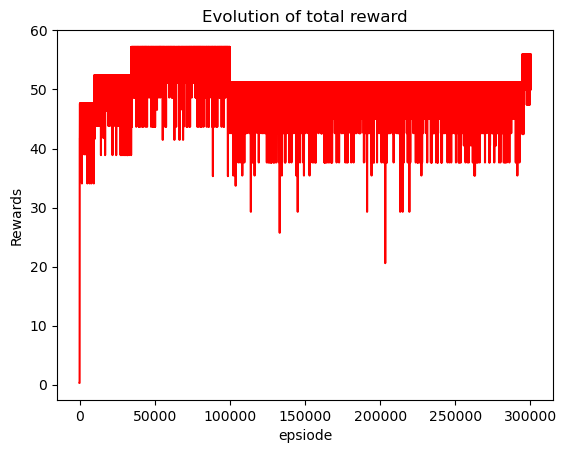

In [125]:
plt.plot(rewards_total,'r')

plt.title('Evolution of total reward')
plt.ylabel('Rewards')
plt.xlabel('epsiode')
plt.show()

After the learning is successful, we can visualize the learned robot controller. Remember we learn this just from interacting with the environment instead of peeking into the dynamics model!

In [126]:
env = KTAICrawlerEnv(render=True, horizon=500)
prev_state = env.reset()
ret = 0.
done = False

while not done:
    action = np.argmax(q_vals[prev_state])
    state, reward, done, info = env.step(action)
    ret += reward
    prev_state = state
    time.sleep(0.01)

In [127]:
# you can close the visualization GUI with the following method 
env.close_gui()